In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2
import os
import seaborn as sns
import pandas as pd
import pickle
sns.set_style('white')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)


import scipy as sp
from scipy import signal
import dlib
from time import time

#for filter
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;
from scipy.interpolate import interp1d
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

from imutils.video import VideoStream
from imutils.video import FPS
import imutils
import time

In [2]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2
 
    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

## With Face Detection

In [209]:
isinMac = True
file = "P00010"
video = "20221213T191547"


if isinMac:
    filelocation = "../../../../rishiraj/Documents/thermal-project-data/cycling/Full_Study/"+file+"/"+video+".MP4"
else:
    filelocation = "G:/Other computers/My MacBook Air/thermal-project-data/cycling/Full_Study/"+file+"/"+video+".MP4"

capture = cv2.VideoCapture(filelocation)
net = cv2.dnn.readNetFromCaffe("face-detection-model/deploy.prototxt", "face-detection-model/res10_300x300_ssd_iter_140000_fp16.caffemodel")
# get the frame rate
fps = capture.get(cv2.CAP_PROP_FPS)
totalFrames = capture.get(cv2.CAP_PROP_FRAME_COUNT)
print("Frame Rate = {}, Total Frames = {}".format(fps, totalFrames))

(ret, frame) = capture.read()
frame = imutils.resize(frame, width=500)
blob = cv2.dnn.blobFromImage(frame, 1.0,(300, 300), (104.0, 177.0, 123.0))
net.setInput(blob)
detections = net.forward()  
confidence = detections[0, 0, i, 2]
box = detections[0, 0, 0, 3:7] * np.array([w, h, w, h])
(startX, startY, endX, endY) = box.astype("int")
cv2.rectangle(frame, (startX+55, startY+90), (endX-45, endY-120),(0, 0, 255), 2)
cv2.imshow('frame', frame)
# wait infinitely until a key is pressed.
cv2.waitKey(0)

capture.release()
cv2.destroyAllWindows() 
'''
while True:
    (ret, frame) = capture.read()
    if not ret:
        break;
    
    frame = imutils.resize(frame, width=500)
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0,(300, 300), (104.0, 177.0, 123.0))
    
    
    # forward pass the caffe model
    net.setInput(blob)
    detections = net.forward()  
    i = 0 # usually the first index is the face
    confidence = detections[0, 0, i, 2]
    
    if confidence > 0.2:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        cv2.rectangle(frame, (startX+45, startY+90), (endX-45, endY-120),(0, 0, 255), 2)
    
    cv2.imshow('frame', frame)
    key = cv2.waitKey(1)
    if key == ord('q'):
        break

capture.release()
cv2.destroyAllWindows() 
'''

Frame Rate = 8.57213325903664, Total Frames = 1564.0


'\nwhile True:\n    (ret, frame) = capture.read()\n    if not ret:\n        break;\n    \n    frame = imutils.resize(frame, width=500)\n    (h, w) = frame.shape[:2]\n    blob = cv2.dnn.blobFromImage(frame, 1.0,(300, 300), (104.0, 177.0, 123.0))\n    \n    \n    # forward pass the caffe model\n    net.setInput(blob)\n    detections = net.forward()  \n    i = 0 # usually the first index is the face\n    confidence = detections[0, 0, i, 2]\n    \n    if confidence > 0.2:\n        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])\n        (startX, startY, endX, endY) = box.astype("int")\n        cv2.rectangle(frame, (startX+45, startY+90), (endX-45, endY-120),(0, 0, 255), 2)\n    \n    cv2.imshow(\'frame\', frame)\n    key = cv2.waitKey(1)\n    if key == ord(\'q\'):\n        break\n\ncapture.release()\ncv2.destroyAllWindows() \n'

## With Manual ROI Selection

In [3]:
tracker = "csrt"
OPENCV_OBJECT_TRACKERS = {
    "csrt": cv2.TrackerCSRT_create,
    "kcf": cv2.TrackerKCF_create,
    "boosting": cv2.legacy.TrackerBoosting_create,
    "mil": cv2.TrackerMIL_create,
    "tld": cv2.legacy.TrackerTLD_create,
    "medianflow": cv2.legacy.TrackerMedianFlow_create,
    "mosse": cv2.legacy.TrackerMOSSE_create
}
# grab the appropriate object tracker using our dictionary of
# OpenCV object tracker objects
tracker = OPENCV_OBJECT_TRACKERS[tracker]()
initBB = None;
pixelIntensityB = np.array([])
pixelIntensityG = np.array([])
pixelIntensityR = np.array([])

# current work area
isinMac = True
file = "P00006"
video = "20221212T162445"

if isinMac:
    filelocation = "../../../../rishiraj/Documents/thermal-project-data/cycling/Full_Study/"+file+"/"+video+".MP4"
else:
    filelocation = "G:/Other computers/My MacBook Air/thermal-project-data/cycling/Full_Study/"+file+"/"+video+".MP4"


capture = cv2.VideoCapture(filelocation)
fps = capture.get(cv2.CAP_PROP_FPS)


# input ROI in the first frame
(ret, frame) = capture.read()
frame = imutils.resize(frame, width=500)
cv2.imshow("Frame", frame)
initBB = cv2.selectROI("Frame", frame, fromCenter=False,showCrosshair=True)
tracker.init(frame, initBB)

while True:
    (ret, frame) = capture.read()
    if not ret:
        break;
    frame = imutils.resize(frame, width=500)
    (H, W) = frame.shape[:2]
    
    if initBB is not None:
        (success, box) = tracker.update(frame)
        tempFrame = frame[box[1]:box[1]+box[3],box[0]:(box[0]+box[2]),0]
        cv2.imshow("temp", tempFrame)
        pixelIntensityB = np.append(pixelIntensityB, np.mean(frame[box[1]:box[1]+box[3],box[0]:(box[0]+box[2]),0]))
        pixelIntensityG = np.append(pixelIntensityG, np.mean(frame[box[1]:box[1]+box[3],box[0]:(box[0]+box[2]),1]))
        pixelIntensityR = np.append(pixelIntensityR, np.mean(frame[box[1]:box[1]+box[3],box[0]:(box[0]+box[2]),2]))
        if success:
            (x, y, w, h) = [int(v) for v in box]
            cv2.rectangle(frame, (x, y), (x + w, y + h),(0, 255, 0), 2)
            info = [ ("Tracker", tracker), 
                    ("Success", "Yes" if success else "No")]
                    #("FPS", "{:.2f}".format(fps.fps())),]
            
            # update the FPS counter
            #fps.update()
            #fps.stop()
            
            for (i, (k, v)) in enumerate(info):
                text = "{}: {}".format(k, v)
                cv2.putText(frame, text, (10, H - ((i * 20) + 20)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    
    #if key == ord("s"):
    #    initBB = cv2.selectROI("Frame", frame, fromCenter=False,showCrosshair=True)
    #    tracker.init(frame, initBB)
        #fps = FPS().start()
    if key == ord("q"):
        break
    
capture.release()
cv2.destroyAllWindows()


'\nsignal = filteredA\n\nsecondsAfter = int(fps*10)+1 # we want to report BRPM after every 10s\nfor i in range(0, signal.shape[0], secondsAfter):\n    if i+secondsAfter>signal.shape[0]:\n        F,A = compute_fft(signal[i:signal.shape[0]], fps)\n        plt.plot(list(signal[i:signal.shape[0]]))\n        plt.show()\n    else:\n        F,A = compute_fft(signal[i:i+secondsAfter], fps)\n        plt.plot(list(signal[i:i+secondsAfter]))\n        plt.show()\n    highestFreq = F[np.argmax(A[1:])+1]\n    print(highestFreq*60)\n'

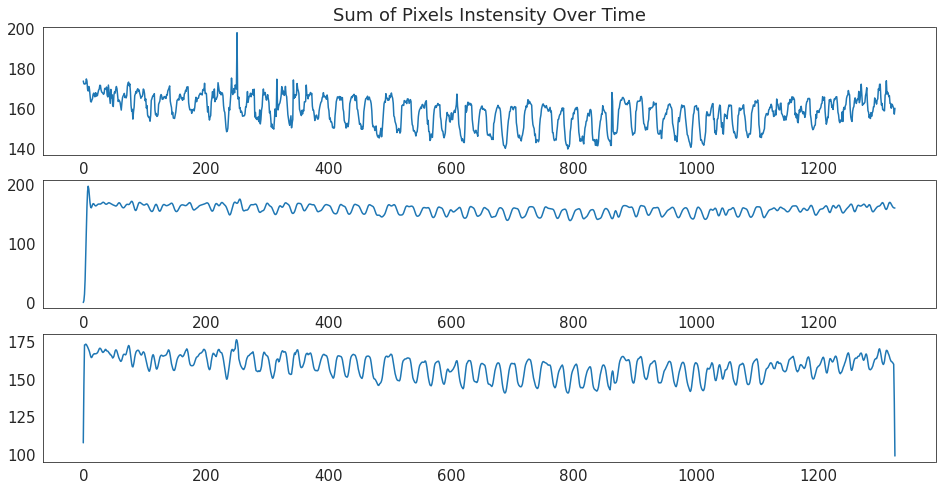

In [8]:
# can be used to smooth the signal if required 
intensity = pixelIntensityR

size = 5
window = sp.signal.gaussian(M=size, std=2)
window /= window.sum()
filteredA = np.convolve(intensity, window, mode='same')
lpf_filtered = butter_lowpass_filter(intensity, 1, fps, order=5)
fig, ax = plt.subplots(3,1, figsize=(16,8))
ax[0].plot(intensity)
ax[0].set_title("Sum of Pixels Instensity Over Time")
ax[1].plot(lpf_filtered)
#ax[1].set_title("Filtered Using LPF of Cutoff 1 Hz")
ax[2].plot(filteredA)
#ax[2].set_title("Filtered Using Gaussian Filter")
#ax[0].set_xlim(10,500);ax[1].set_xlim(10,500)

# perform FFT

'''
signal = filteredA

secondsAfter = int(fps*10)+1 # we want to report BRPM after every 10s
for i in range(0, signal.shape[0], secondsAfter):
    if i+secondsAfter>signal.shape[0]:
        F,A = compute_fft(signal[i:signal.shape[0]], fps)
        plt.plot(list(signal[i:signal.shape[0]]))
        plt.show()
    else:
        F,A = compute_fft(signal[i:i+secondsAfter], fps)
        plt.plot(list(signal[i:i+secondsAfter]))
        plt.show()
    highestFreq = F[np.argmax(A[1:])+1]
    print(highestFreq*60)
'''

In [24]:
#3 in 10 seconds
(1/5)*60

12.0